# MLP for Dataset Version 3 (Dimension Reduction) + Optimized Hyperparameter + Metaheuristic Initialization

1. Import Necessary Libraries:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt

import time

from RandomInitializer import *
from QuasirandomInitializer import *
from SphereInitializer import *
from Bounds import *
from LinearInertia import *

from DE import *
from PSO import *
from Jaya import *
from GA import *

2. Preparing Data:

In [2]:
data = pd.read_csv("../DataVersion3.csv")

In [3]:
data.shape

(25794, 17)

In [4]:
data_reduced_dim = pd.read_csv("../TruncatedSVD_50.csv", header = None)

In [5]:
data_reduced_dim.shape

(25794, 50)

In [6]:
# Split data into train, validation, and test sets
X = data_reduced_dim.values
y = data["price_in_billion"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
X.shape

(25794, 50)

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
class CarDataset(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
train_dataset = CarDataset(X_train, y_train)
val_dataset = CarDataset(X_val, y_val)
test_dataset = CarDataset(X_test, y_test)

# Load the saved DataLoader objects
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [11]:
#MLP for regresion
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2: 
                layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


: 

In [12]:
layer_sizes = [50]

hidden_layer_sizes = [6, 4, 2] 
layer_sizes.extend(hidden_layer_sizes)

layer_sizes.append(1)

model = MLP(layer_sizes)

optimizer = optim.Adam(model.parameters(), lr = 0.0023340117186307907, weight_decay = 6.818751742897769e-05)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MLP(
  (network): Sequential(
    (0): Linear(in_features=50, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=2, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [14]:
################################################################
#  SwarmObjective
#
class SwarmObjective:
    def __init__(self, model):
        """Keep the NN object and test data"""
        self.model = model

    def Evaluate(self, params, criterion = nn.MSELoss(), device = device, data_evaluate_on = train_loader):
    # Set the parameters in the model
        idx = 0
        for p in self.model.parameters():
            p.data = torch.tensor((params[idx:idx + p.numel()]).reshape(p.size())).float().to(device)
            idx += p.numel()
        
        loss = 0
        self.model.eval()
        for (data, target) in data_evaluate_on:
            with torch.no_grad():
                outputs = self.model(data.to(device))
                loss += criterion(outputs, target.to(device)).item()
        return loss/len(data_evaluate_on)


################################################################
#  Set weights
#
def SetWeights(model, params):
    """Set the weight of the given NN object"""
    idx = 0
    for p in model.parameters():
        numel = p.numel()
        p.data = torch.tensor(params[idx:idx + numel]).reshape(p.size()).float()
        idx += numel

################################################################
#  main
#
def main(npart, niter, itype):
    '''train the models
    <npart>  - number of swarm particles
    <niter>  - number of swarm iterations
    RI|QI|SI - swarm initializer'''

    ndim = sum(p.numel() for p in model.parameters())

    #  For tracking performance
    val_loss = []
    running_time = []
    M = []

    obj = SwarmObjective(model)

    #  Use very small initial weights
    b = Bounds(-0.01*np.ones(ndim), 0.01*np.ones(ndim), enforce="resample")

    if (itype == "SI"):
        i = SphereInitializer(npart, ndim, bounds=b)
    elif (itype == "QI"):
        i = QuasirandomInitializer(npart, ndim, bounds=b)
    else:
        i = RandomInitializer(npart, ndim, bounds=b)

    #  But increase the range allowed by the weights
    b = Bounds(-10*np.ones(ndim), 10*np.ones(ndim), enforce="resample")

    #  Loop over algorithms
    for alg in ["PSO","DE","JAYA","GA"]:
        print(alg)
        if (alg == "PSO"):
            swarm = PSO(obj=obj, npart=npart, ndim=ndim, max_iter=niter, init=i, bounds=b, inertia=LinearInertia())
        elif (alg == "DE"):
            swarm = DE(obj=obj, npart=npart, ndim=ndim, max_iter=niter, init=i, bounds=b)
        elif (alg == "JAYA"):
            swarm = Jaya(obj=obj, npart=npart, ndim=ndim, max_iter=niter, init=i, bounds=b)
        elif (alg == "GA"):
            swarm = GA(obj=obj, npart=npart, ndim=ndim, max_iter=niter, init=i, bounds=b)

        start = time.time()
        swarm.Optimize()
        end = time.time()
        running_time.append(end - start)

        SetWeights(obj.model, swarm.gpos[-1])
        loss = obj.Evaluate(swarm.gpos[-1], data_evaluate_on = val_loader)

        val_loss.append(loss)
        M.append(alg)

    #  Rank the results by loss on the validation set
    val_loss = np.array(val_loss)
    idx = np.argsort(val_loss)
    val_loss = val_loss[idx]
    M = np.array(M)[idx]
    running_time = np.array(running_time)[idx]

    #  Results
    print("Ranked: (npart=%d, niter=%d)" % (npart, niter))
    print("Val Loss  time")
    for i in range(len(M)):
        print("%7.4f  %.3f  %s" % (val_loss[i], running_time[i], M[i]))
    print()

main(5, 8, "RI")



PSO
Iter 1/8, best training loss: 2.3928
Iter 2/8, best training loss: 2.3928
Iter 3/8, best training loss: 2.3921
Iter 4/8, best training loss: 2.3905
Iter 5/8, best training loss: 2.3861
Iter 6/8, best training loss: 2.3850
Iter 6/8, best training loss: 2.3825
Iter 7/8, best training loss: 2.3792
Iter 7/8, best training loss: 2.3785
Iter 8/8, best training loss: 2.3750
Iter 8/8, best training loss: 2.3744
Iter 8/8, best training loss: 2.3733
DE
Iter 2/8, best training loss: 2.3917
Iter 3/8, best training loss: 2.3911
Iter 4/8, best training loss: 2.3884
Iter 6/8, best training loss: 2.3855
Iter 6/8, best training loss: 2.3835
Iter 7/8, best training loss: 2.3790
Iter 8/8, best training loss: 2.3753
JAYA
Iter 1/8, best training loss: 2.3866
Iter 2/8, best training loss: 2.3781
Iter 3/8, best training loss: 2.3732
Iter 3/8, best training loss: 2.3708
Iter 4/8, best training loss: 2.3620
Iter 5/8, best training loss: 2.3503
Iter 6/8, best training loss: 2.3357
Iter 7/8, best training lo

In [ ]:
idx = 0
for param in model.parameters():
        print(param.size())
        print(idx)
        idx += param.numel()
        print(idx)
dims = sum(p.numel() for p in model.parameters())
print(dims)

torch.Size([111, 50])
0
5550
torch.Size([111])
5550
5661
torch.Size([122, 111])
5661
19203
torch.Size([122])
19203
19325
torch.Size([80, 122])
19325
29085
torch.Size([80])
29085
29165
torch.Size([1, 80])
29165
29245
torch.Size([1])
29245
29246
29246


1. PSO

In [18]:
import pyswarms as ps

def objective_function(x):
    """Higher-level method to do forward_prop in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [forward_prop(x[i], model, criterion, test_loader, device) for i in range(n_particles)]
    return np.array(j)

dims = sum(p.numel() for p in model.parameters())
lb = -10 * np.ones(dims)
ub = 10 * np.ones(dims)

options = {'c1': 1.49, 'c2': 1.49, 'w': 0.729, 'k': 8, 'p': 2}
optimizer = ps.single.LocalBestPSO(n_particles=50, dimensions=dims, options=options, bounds=(lb, ub))

# Perform optimization
best_loss, best_params = optimizer.optimize(objective_function, iters=50)
print(f"Best PSO Loss: {best_loss}")



2024-05-28 18:22:03,149 - pyswarms.single.local_best - INFO - Optimize for 50 iters with {'c1': 1.49, 'c2': 1.49, 'w': 0.729, 'k': 8, 'p': 2}
pyswarms.single.local_best:  68%|██████▊   |34/50, best_cost=3.22e+9 

2. Jaya

In [1]:
from pyJaya import jaya

best_params, best_loss = jaya(forward_prop, lb, ub, pop_size=30, max_iter=100)
print(f"Best Jaya Loss: {best_loss}")

idx = 0
for p in model.parameters():
    numel = p.numel()
    p.data = torch.tensor(best_params[idx:idx + numel]).reshape(p.size()).float()
    idx += numel



ImportError: cannot import name 'jaya' from 'pyJaya' (c:\Users\fpt47\miniconda3\envs\pytorch-gpu-python-3-11\Lib\site-packages\pyJaya\__init__.py)

Epoch [1/90], Loss: 0.1249, Val Loss: 0.5356
Epoch [2/90], Loss: 0.1544, Val Loss: 0.5603
Epoch [3/90], Loss: 0.2535, Val Loss: 0.5364
Epoch [4/90], Loss: 0.2410, Val Loss: 0.5254
Epoch [5/90], Loss: 0.1075, Val Loss: 0.5656
Epoch [6/90], Loss: 0.2685, Val Loss: 0.5931
Epoch [7/90], Loss: 0.0859, Val Loss: 0.5842
Epoch [8/90], Loss: 0.0702, Val Loss: 0.5662
Epoch [9/90], Loss: 0.3889, Val Loss: 0.5347
Epoch [10/90], Loss: 0.2327, Val Loss: 0.5305
Epoch [11/90], Loss: 0.3328, Val Loss: 0.5357
Epoch [12/90], Loss: 0.1874, Val Loss: 0.5391
Epoch [13/90], Loss: 0.2055, Val Loss: 0.5158
Epoch [14/90], Loss: 0.1083, Val Loss: 0.5228
Epoch [15/90], Loss: 0.1554, Val Loss: 0.5625
Epoch [16/90], Loss: 0.1805, Val Loss: 0.5611
Epoch [17/90], Loss: 0.3067, Val Loss: 0.5440
Epoch [18/90], Loss: 0.1176, Val Loss: 0.5389
Epoch [19/90], Loss: 0.1777, Val Loss: 0.5563
Epoch [20/90], Loss: 0.1619, Val Loss: 0.5354
Epoch [21/90], Loss: 0.2291, Val Loss: 0.5876
Epoch [22/90], Loss: 0.0787, Val Loss: 0.56

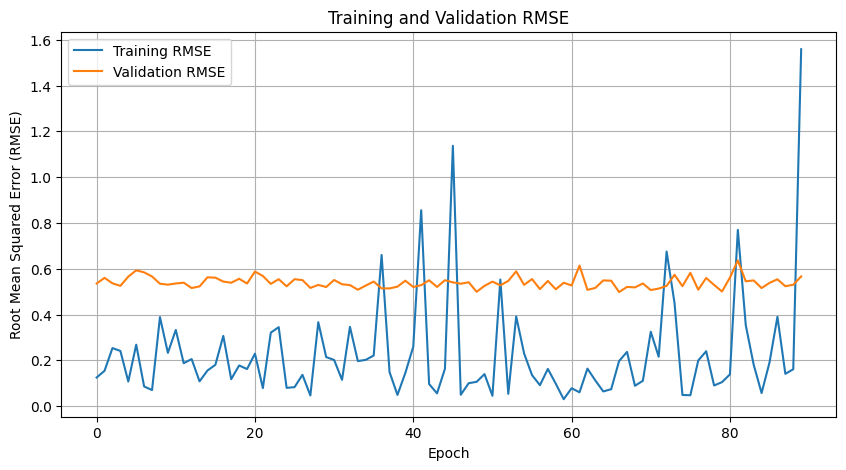

In [ ]:
train_losses = []
val_losses = []

start_time = datetime.now()
# Training loop with early stopping
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 20
num_epochs = 90
with open("result.txt", "a") as f:
    f.write("TruncatedSVD_50" + '\n')
    f.write(f"MLP with layer size: {hidden_layer_sizes} - Result:\n")
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for (data, target) in train_loader:
            data, target = data.to(device), target.to(device)  # Move data to the device
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
        val_loss /= len(val_loader)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        elif val_loss - best_val_loss < 0.005:
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping at epoch {epoch}')
                f.write(f'Early stopping at epoch {epoch}' + '\n')
                break
        train_losses.append(np.sqrt(loss.item())) # Store RMSE for training
        val_losses.append(np.sqrt(val_loss))       # Store RMSE for validation
        result = f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.sqrt(loss.item()):.4f}, Val Loss: {np.sqrt(val_loss):.4f}'
        print(result)
        f.write(result + "\n")
    running_time = datetime.now() - start_time
    print("Runtime: ", running_time)
    f.write(f"Runtime: {running_time}" + '\n')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training RMSE')
plt.plot(val_losses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
all_preds = np.empty((0, 1))
all_targets = np.empty((0, 1))
with open("result.txt", "a") as f:
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            all_preds = np.vstack((all_preds, outputs.cpu().numpy()))
            all_targets = np.vstack((all_targets, targets.cpu().numpy()))
    
    # Flatten arrays to 1D
    all_preds = all_preds.flatten()
    all_targets = all_targets.flatten()

    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_targets - all_preds) / all_targets)) * 100
    
    print(f'R^2 Score: {r2:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%')

    f.write(f'R^2 Score: {r2:.4f}' + '\n')
    f.write(f'RMSE: {rmse:.4f}' + '\n')
    f.write(f'MAE: {mae:.4f}' + '\n')